In [1]:
%load_ext autoreload
%autoreload 2

### Importation des bibliothèques

In [2]:
from tqdm import tqdm
from collections import Counter, defaultdict
import os
os.chdir("..")

# my modules
from Preprocessors.ReviewPreprocessor import ReviewPreprocessor
from Aspects.ExplicitAspectExtractor import ExplicitAspectExtractor
from Aspects.CoRefAspectIdentGrouping import CoRefAspectIdentGrouping

# pandas and numpy
import pandas as pd
import numpy as np

# spacy for NLP
import spacy
from spacy.matcher import Matcher

from time import time

#ignore pandas warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# plots
import seaborn as sns

nlp = spacy.load("en_core_web_sm")

### Importation des données

le dataset utilisé 3000 commentaires, extraite depuis une grande dataset de 50 Million commentaires dans TripAdvisor. [lien vers le dataset](https://www.aclweb.org/anthology/2020.lrec-1.605)

les attributes de dataset créé:
- **hotel_url**: lien de l'hotel commenté;
- **author**: l'auteur de commentaire;
- **date**: date de publication de commentaire;
- **rating**: le score attribué par l'auteur à l'hotel;
- **title**: titre de commentaire;
- **review**: le text de commentaire.

In [3]:
data = pd.read_csv("data/trip_advisor_data_chunk_10000k.csv", encoding="utf-16")
data.rename(columns={"text": "review"}, inplace=True)
print(f"format de dataset: {data.shape}")
data.head(5)

format de dataset: (3000, 6)


,hotel_url,author,date,rating,title,review
0,Hotel_Review-g194775-d1121769-Reviews-Hotel_Ba...,Lagaiuzza,2016-01-01T00:00:00,5.0,"Baltic, what else?",We have spent in this hotel our summer holiday...
1,Hotel_Review-g194775-d1121769-Reviews-Hotel_Ba...,ashleyn763,2014-10-01T00:00:00,5.0,Excellent in every way!,I visited Hotel Baltic with my husband for som...
2,Hotel_Review-g194775-d1121769-Reviews-Hotel_Ba...,DavideMauro,2014-08-01T00:00:00,5.0,The house of your family's holiday,I've travelled quite a numbers of hotels but t...
3,Hotel_Review-g303503-d1735469-Reviews-Pousada_...,TwoMonkeysTravel,2017-03-01T00:00:00,5.0,Natural Luxury,"The property is surrounded by trees, which are..."
4,Hotel_Review-g303503-d1735469-Reviews-Pousada_...,analuizade,2016-09-01T00:00:00,5.0,Very cozy!,I had a very pleasant stay at this hotel! All ...


### Prétraitement de données

#### suppression des caractéristiques inutiles. (\n, \t, \r, hyperlinks, #..., @..., les emojis)

Après l'analyse des commentaires. Nous avons remarqué que le dataset contient des mots en dialecte marocain -darija-. Ainsi nous les considérons comme des mots corrects.

In [4]:
preprocessor = ReviewPreprocessor(data['review'], spell_allowed_words= ["riad", "dar","rif"], nlp=nlp, subjectivity_threshold=0.6)
data['cleaned_review'] = preprocessor.remove_tags()
data['cleaned_review']

0       We have spent in this hotel our summer holiday...
1       I visited Hotel Baltic with my husband for som...
2       I've travelled quite a numbers of hotels but t...
3       The property is surrounded by trees, which are...
4       I had a very pleasant stay at this hotel! All ...
                              ...                        
2995    We stayed in Portland for three nights and thi...
2996    It was my third time to stay at University pla...
2997    Stayed here for 4 nights in March and I chose ...
2998    I didn't expect much from this hotel from the ...
2999    The hotel rooms were clean and comfortable. Ni...
Name: cleaned_review, Length: 3000, dtype: object

#### correction des fautes d'orthographes

Pour la correction des fautes d'orthographes, nous avons adopté la procédure suivante: premièrement, on parcourt les commentaires une par une. Ensuite on extrait les mots de commentaire traitée. On utilise la bibliothèque **pyspellchecker**, qui utilise la norme de levenshtein pour corriger les mots mal tapés.

Pour vérifier la procédure. nous modifions le commentaire d'indice 0:

**Contenu de commentaire**
'We have spent in this hotel our summer holidays both in summer 2014 and 2015- I was with my husband and my child ( 4 years old at present). I do really recommend this place- Staff si high qualified, Kind and really helpful- Animation staff get You involved, but always with discrection - Miniclub si super and activities offered are interesting and smart- Rooms clean, with AC and balcony- Restaurant offers a great selection of food - always. The beach si extremly closed to the hotel - Miniclub area offers some gazebos to have shade for kids- A lot of bicycles are available for free- I am completely satisfied of this hotel- Go in lime this!'

les modification appliqué:
- We -> Wee
- have -> haavee
- spent -> spant
- in -> ine

In [5]:
data.loc[0, "review"] = 'Wee haavee spant ine this hotel our summer holidays both in summer 2014 and 2015- I was with my husband and my child ( 4 years old at present). I do really recommend this place- Staff si high qualified, Kind and really helpful- Animation staff get You involved, but always with discrection - Miniclub si super and activities offered are interesting and smart- Rooms clean, with AC and balcony- Restaurant offers a great selection of food - always. The beach si extremly closed to the hotel - Miniclub area offers some gazebos to have shade for kids- A lot of bicycles are available for free- I am completely satisfied of this hotel- Go in lime this!'
data.loc[0, "review"]

'Wee haavee spant ine this hotel our summer holidays both in summer 2014 and 2015- I was with my husband and my child ( 4 years old at present). I do really recommend this place- Staff si high qualified, Kind and really helpful- Animation staff get You involved, but always with discrection - Miniclub si super and activities offered are interesting and smart- Rooms clean, with AC and balcony- Restaurant offers a great selection of food - always. The beach si extremly closed to the hotel - Miniclub area offers some gazebos to have shade for kids- A lot of bicycles are available for free- I am completely satisfied of this hotel- Go in lime this!'

In [6]:
data['cleaned_review'] = preprocessor.spelling_correction()
data['cleaned_review'][0]

3000it [11:37,  4.30it/s]


'We have spent in this hotel our summer holidays both in summer 2014 and 2015- I was with my husband and my child ( 4 years old at present). I do really recommend this place- Staff si high qualified, Kind and really helpful- Animation staff get You involved, but always with discretion - minicab si super and activities offered are interesting and smart- Rooms clean, with AC and balcony- Restaurant offers a great selection of food - always. The beach si extremly closed to the hotel - minicab area offers some gazebos to have shade for kids- A lot of bicycles are available for free- I am completely satisfied of this hotel- Go in lime this!'

les mots modifier dans le commentaires avec indice 0 sont bien corrigés, mais le mot 'si' n'est pas corrigé.

#### suppression des phrases objectives

In [7]:
data['cleaned_review'] = preprocessor.remove_objective_sentences()
data['cleaned_review'][0]

3000it [01:33, 32.25it/s]


'I was with my husband and my child ( 4 years old at present). Rooms clean, with AC and balcony- Restaurant offers a great selection of food - always. A lot of bicycles are available for free- I am completely satisfied of this hotel- Go in lime this!'

les phrases supprimé dans le commentaire 0 :
- We have spent in this hotel our summer holidays both in summer 2014 and 2015
- Staff si high qualified, Kind and really helpful- Animation staff get You involved, but always with discrection
- The beach si extremly closed to the hotel - minicab area offers some gazebos to have shade for kids-


In [8]:
from textblob import TextBlob
TextBlob("Staff si high qualified, Kind and really helpful- Animation staff get You involved, but always with discrection").subjectivity

0.5466666666666666

In [9]:
TextBlob("Staff si high qualified, Kind and really helpful").subjectivity

0.5466666666666666

In [10]:
TextBlob("Animation staff get You involved, but always with discrection").subjectivity

0.0

In [11]:
TextBlob("I was with my husband and my child ( 4 years old at present)").subjectivity

0.1

**Remarques:**
- la deuxième phrase est supprimé à cause de son score de subjectivité inférieur au seuil 0.6
- il y a un problème dans l'étape de prétraitement. dans le cas de la phrase le symbole '-' est lié à l'adjectif helpful, car dans cette commentaire l'auteur à écrit une liste des phrases et lors de la suppression de \n, le symbole '-' sera concaténé par le mot qui le précède.

### Extraction des aspects explicites

Dans cette phase, on extrait les noms les plus fréquents comme des aspects explicites.

In [12]:
now = time()
aspect_extractor = ExplicitAspectExtractor(data["cleaned_review"], nlp)
extracted_aspects = aspect_extractor.start(60)
print(extracted_aspects)
print(f"extracting aspects {time() - now}s")

[('room', 2647), ('hotel', 2090), ('staff', 1280), ('breakfast', 951), ('food', 746), ('place', 746), ('restaurant', 654), ('time', 641), ('night', 635), ('day', 612), ('location', 590), ('service', 548), ('bed', 523), ('area', 478), ('pool', 401), ('beach', 372), ('stay', 372), ('water', 342), ('resort', 328), ('bathroom', 311), ('bar', 309), ('view', 303), ('price', 296), ('lot', 290), ('minute', 275), ('shower', 264), ('kid', 249), ('people', 248), ('guest', 244), ('experience', 242), ('dinner', 242), ('way', 238), ('thing', 235), ('family', 229), ('desk', 219), ('bit', 218), ('trip', 215), ('morning', 208), ('meal', 199), ('door', 196), ('floor', 195), ('coffee', 195), ('parking', 189), ('drink', 175), ('city', 170), ('evening', 166), ('reception', 161), ('riad', 159), ('year', 158), ('choice', 155), ('street', 155), ('problem', 151), ('walk', 151), ('hour', 150), ('child', 149), ('air', 149), ('quality', 146), ('town', 142), ('star', 140), ('facility', 139)]
extracting aspects 51.

on remarque que les aspects les plus fréquents sont:
- room
- hotel
- staff
- location
- breakfast
- time
- restaurant
- service
- stay

...

### Groupement des aspects similaires (Co-referencial aspect identification and grouping)

Après l'extraction des aspects explicites. L'objectif de cette étape est le groupements des aspects explicite qui ont un sens similaire, exemple le groupe (food, breakfast, dinner).

Pour atteindre cette objectif, nous proposons d'utiliser le modèle **Word2Vec**. ce dernier est entraîné sur les phrases des commentaires. Ensuite, pour chaque couple d'aspects explicites, on calcule la similarité entre eux à l'aide du modèle construit.

On calcule la matrice de cooccurrence entre les aspects explicites et les mots qui exprime un sentiment (des adjectifs). Cette matrice sera utilisée pour l'extraction des aspects implicites.

#### Création de la matrice de co-occurrence entre les aspects explicite et les mots de sentiments

In [13]:
aspects_ = list(dict(extracted_aspects).keys())

In [14]:
co_ref_aspect_ident_grouping = CoRefAspectIdentGrouping(data[["review", "cleaned_review"]], dict(extracted_aspects), nlp)
aspect_sentiment = co_ref_aspect_ident_grouping.get_co_occurrence_matrix()
aspect_sentiment

,room,hotel,staff,breakfast,food,place,restaurant,time,night,day,...,street,problem,walk,hour,child,air,quality,town,star,facility
old,32.0,36.0,7.0,6.0,6.0,6.0,4.0,7.0,8.0,4.0,...,4.0,0.0,1.0,2.0,6.0,0.0,3.0,10.0,1.0,1.0
present,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
clean,444.0,140.0,109.0,59.0,34.0,32.0,17.0,10.0,15.0,17.0,...,2.0,2.0,3.0,3.0,5.0,9.0,8.0,3.0,7.0,15.0
balcony-,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
great,155.0,165.0,145.0,111.0,108.0,95.0,68.0,49.0,31.0,30.0,...,9.0,4.0,11.0,3.0,15.0,4.0,5.0,14.0,10.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
troubling,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
trim,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
satisfying,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
extinguisher,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Groupement des aspects explicites

la procédure proposé crée des couples des aspects explicites similaire, exemple:

Ensuite, on applique un algorithme pour grouper les couples qui ont au moins un élément partagé, et d'une manière récursive.

Le résultat de groupement:

In [15]:
co_ref_aspects = co_ref_aspect_ident_grouping.get_co_reference_aspects_groups(0.68)
co_ref_aspects

3000it [01:22, 36.55it/s]


{'staff': ['staff'],
 'people': ['people', 'guest'],
 'bit': ['bit'],
 'facility': ['facility'],
 'way': ['way'],
 'room': ['air', 'bed', 'room', 'bathroom', 'shower'],
 'breakfast': ['night',
  'dinner',
  'breakfast',
  'coffee',
  'quality',
  'meal',
  'food',
  'hour',
  'choice',
  'day',
  'morning',
  'price',
  'evening',
  'drink'],
 'star': ['star'],
 'location': ['town', 'location', 'city', 'street'],
 'minute': ['minute'],
 'kid': ['child', 'kid', 'family'],
 'beach': ['beach'],
 'restaurant': ['restaurant'],
 'desk': ['reception', 'desk'],
 'service': ['service'],
 'walk': ['walk'],
 'water': ['water'],
 'floor': ['floor'],
 'area': ['area'],
 'thing': ['thing'],
 'view': ['view'],
 'pool': ['pool'],
 'experience': ['experience'],
 'year': ['year'],
 'problem': ['problem'],
 'hotel': ['hotel', 'place'],
 'resort': ['resort', 'riad'],
 'stay': ['stay'],
 'door': ['door'],
 'lot': ['lot'],
 'bar': ['bar'],
 'time': ['time'],
 'parking': ['parking'],
 'trip': ['trip']}

### Extraction des aspects implicites

La procédure proposée est inspirée de l'article [2]. Premièrement on identifie les phrases subjectives qui ne contiennent pas un aspect explicite, puis on extrait les adjectifs (sentiments) dans cette phrase, afin de trouver les aspects explicites qui coexistent fréquemment avec chaque adjectif.

In [16]:
aspects = list(dict(extracted_aspects).keys())

In [17]:
pattern = [{"POS": "ADJ"}]
matcher = Matcher(nlp.vocab)
matcher.add("SENTIMENT_WORDS", [pattern])

for id_, review in data["cleaned_review"].items():
    doc = nlp(review)
    for sentence in doc.sents:
        aspects_in_sentence = [i for i in aspects if i in sentence.text.lower()]
        if len(aspects_in_sentence) == 0:
            print(f"review id : {id_}")
            # extract ADJ
            adjs = matcher(sentence)
            for id_matcher, start, end in adjs:
                sentiment_word = sentence[start:end].text
                if sentiment_word in list(aspect_sentiment.index):
                    implicit_aspect = aspect_sentiment.loc[sentiment_word].sort_values(ascending=False).index[0]
                    print(f"sentiment word : {sentiment_word}, aspect : {implicit_aspect}")
                    print(sentence.text)
            print("=========")

review id : 1
sentiment word : wrong, aspect : room
I was so wrong.
review id : 1
sentiment word : amazing, aspect : staff
It was truly amazing.
review id : 2
sentiment word : excellent, aspect : staff
The equip is really excellent.
review id : 2
review id : 5
review id : 5
sentiment word : super, aspect : room
They have super cute monkeys (small ones, the size of a cat) leaving on the trees, everyone loved them!
sentiment word : cute, aspect : hotel
They have super cute monkeys (small ones, the size of a cat) leaving on the trees, everyone loved them!
sentiment word : small, aspect : room
They have super cute monkeys (small ones, the size of a cat) leaving on the trees, everyone loved them!
review id : 5
sentiment word : nice, aspect : room
Overall, it was nice and relaxing.
sentiment word : relaxing, aspect : place
Overall, it was nice and relaxing.
review id : 5
review id : 5
sentiment word : great, aspect : hotel
It didn't bother us and we had great sleep.
review id : 8
sentiment w

In [18]:
from Aspects.ImplicitAspectExtractor import ImplicitAspectExtractor

In [19]:
implicit_aspect_extractor = ImplicitAspectExtractor(data["cleaned_review"], aspect_sentiment, nlp)
df_implicit_aspects = implicit_aspect_extractor.extract_implicit_aspects()
df_implicit_aspects

3000it [01:33, 32.20it/s]


,review_id,sentence,implicit_aspects
0,1,I was so wrong.,[room]
1,1,It was truly amazing.,[staff]
2,2,The equip is really excellent.,[staff]
3,5,"They have super cute monkeys (small ones, the ...","[room, hotel, room]"
4,5,"Overall, it was nice and relaxing.","[room, place]"
...,...,...,...
2038,2987,Moderate accommodations with moderate cost..,[location]
2039,2988,It's an old property and dated (is/is era) but...,"[hotel, room]"
2040,2992,Walls were pretty thin.,[room]
2041,2995,That was pretty pathetic.,[hotel]


Après l'application de l'algorithme proposé, on remarque qu'on obtient quelque bon extraction. comme :

malheureusement, il y a des aspects implicite pas bien identifier, comme:

**Remarques:**
- la méthode proposé dans l'extraction des aspects implicite n'analyse pas le context de la phrase, c'est pour cela on obtient des aspects mal identifiée comme dans la phrase 1545, 1050, 2682
- dans la phrase 1050, on remarque un mention explicite de l'aspect 'Staff' par le mot employee, mais on identifie les aspects implicite 'hotel' et 'breakfast'.
- de même pour 2904, l'aspect explicite value et en identifier un aspect implicite 'staff'.

### Les Idées d'amélioration:

#### Prétraitement:

- le processus de correction prend  beaucoup de temps (plus de 11 minutes pour corriger 3000 commentaires). utilisation de calcul parallèle pour traiter plusieurs commentaires en même temps.
- parfois les auteurs utilise des liste dans leurs commentaires. exemple :

Avec la suppression de symbole '\n', les éléments de la liste serait concaténé, ce qui affect la division de commentaires en phrases.

#### Extraction des aspects explicites:

- utilisation de modèle **Word2Vec** Pour extraire les aspects explicites non-fréquents, en calculons la similarité entre un aspect explicite et un aspect explicite non-fréquent.

#### Co-reference aspects identification and grouping

- fixer un nombre maximum d'éléments pour les groupes d'aspects similaires.

### Idée de pour la classification des sentiments:

- Utilisation de NLP pour lier les aspects avec ses mots de sentiment dans chaque phrase. Après on utilise le corpus SentiWordNet avec des règles linguistiques pour déterminer la polarité de l'aspects discuté dans la phrase [3].
- Utilisation d' algorithmes non supervisés.

### Classification des sentiments:

la méthode utilisé pour la classification a été proposé dans une blog [lien de blog](https://medium.com/@pmin91/aspect-based-opinion-mining-nlp-with-python-a53eb4752800) intitulé "Aspect-Based Opinion Mining (NLP with Python)".

La méthode se base sur un lexique d'opinion proposé par Hu et Liu [lien vers le lexicon](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon), pour déterminer la polarité d'un mot. Le lexique contient 64'000 mots divisé en mots positifs et négatifs.

Cette méthode parcourt tous les tokens (mots, ponctuation, numéros, ...) dans la phrase traitée. Si le mot traité dans le lexicon, on obtient sa polarité (à partir de la liste où il appartient). Ensuit on utilise la technique [Dependency Parsing](https://realpython.com/natural-language-processing-spacy-python/#dependency-parsing-using-spacy) [(explication profond)](https://web.stanford.edu/~jurafsky/slp3/14.pdf), pour récépuré la dépendance entre le token traité (sentiment) et les autres token dans la phrase, afin d'extraire l'aspect dont le sentiment est lié, également la négation pour inverser la polarité de mot.

In [21]:
# Load opinion lexicon
neg_file = open("data/opinion-lexicon-English/negative_words.txt",encoding = "ISO-8859-1")
pos_file = open("data/opinion-lexicon-English/positive_words.txt",encoding = "ISO-8859-1")
neg = [line.strip() for line in neg_file.readlines()]
pos = [line.strip() for line in pos_file.readlines()]
opinion_words = neg + pos

In [179]:
def feature_sentiment(sentence):
    '''
    input: dictionary and sentence
    function: appends dictionary with new features if the feature did not exist previously,
              then updates sentiment to each of the new or existing features
    output: updated dictionary
    '''

    sent_dict = Counter()
    debug = 0
    for token in sentence:
    #    print(token.text,token.dep_, token.head, token.head.dep_)
        # check if the word is an opinion word, then assign sentiment
        if token.text in opinion_words:
            sentiment = 1 if token.text in pos else -1
            # if target is an adverb modifier (i.e. pretty, highly, etc.)
            # but happens to be an opinion word, ignore and pass
            if (token.dep_ == "advmod"):
                continue
            elif (token.dep_ == "amod"):
                sent_dict[token.head.lemma_.lower()] += sentiment
            # for opinion words that are adjectives, adverbs, verbs...
            else:
                for child in token.children:
                    print(child)
                    # if there's a adj modifier (i.e. very, pretty, etc.) add more weight to sentiment
                    # This could be better updated for modifiers that either positively or negatively emphasize
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if child.dep_ == "neg":
                        sentiment *= -1
                for child in token.children:
                    # if verb, check if there's a direct object
                    if (token.pos_ == "VERB") & (child.dep_ == "dobj"):
                        sent_dict[child.lemma_.lower()] += sentiment
                        # check for conjugates (a AND b), then add both to dictionary
                        subchildren = []
                        conj = 0
                        for subchild in child.children:
                            if subchild.text == "and":
                                conj=1
                            if (conj == 1) and (subchild.text != "and"):
                                subchildren.append(subchild.lemma_.lower())
                                conj = 0
                        for subchild in subchildren:
                            sent_dict[subchild] += sentiment

                # check for negation
                for child in token.head.children:
                    print(child)
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if (child.dep_ == "neg"):
                        sentiment *= -1
                
                # check for nouns
                for child in token.head.children:
                    noun = ""
                    if (child.pos_ == "NOUN") and (child.text not in sent_dict):
                        noun = child.lemma_.lower()
                        # Check for compound nouns
                        for subchild in child.children:
                            if subchild.dep_ == "compound":
                                noun = subchild.lemma_.lower() + " " + noun
                        sent_dict[noun] += sentiment
                    debug += 1
    return sent_dict

In [22]:
def extract_sentiment_aspect(review):
    sentences = nlp(review).sents
    res = []
    for sentence in sentences:
        f = feature_sentiment(sentence)
        # don't add empty objects
        if f != {}:
            res.append(f)
    return res

In [23]:
data["aspect_sentiment"] = data["cleaned_review"].apply(lambda review: extract_sentiment_aspect(review))

In [24]:
data["aspect_sentiment"]

0               [{'room': 1, 'selection': 1}, {'lot': 1}]
1                                       [{'kindness': 1}]
2       [{'place': 1, 'money': 1}, {'staff': 1}, {'bar...
3                                         [{'shower': 1}]
4       [{'stay': 1}, {'staff': 1}, {'room': 1, 'swimm...
                              ...                        
2995                       [{'price': 1}, {'staff': 1.5}]
2996    [{'i': 1.5, 'time': 2.25, 'staff member': 2.25...
2997    [{'stuff': 1}, {'guy': -1, 'voice': -1}, {'way...
2998    [{'location': 1}, {'staff': 1}, {'breakfast': ...
2999    [{'hotel room': 1}, {'menu variety': 1}, {'ame...
Name: aspect_sentiment, Length: 3000, dtype: object

#### Limitations de la méthode

la méthode souffre de plusieurs limitation:
- Incapable de traité les aspects implicite.
- Il y a des phrase qui ne réspecte pas les régles d'extraction, par concequence aucune aspect/sentiment sera extrait, malgrai que la phrase discute un sentiment sur un aspect, ou bien il tampe dans l'extraction des aspects
    - comme dans le cas de la phrase suivant 'Every time I come here, staff members welcome me warmly and they are really friendly and helpful.' il a extrait le pronom personnel **i** comme un aspect positive et le nom **time** comme un aspect positive

In [57]:
aspects_summary_ = pd.DataFrame(columns= ["aspect", "sentiment", "score"])

In [ ]:
for id_, items in tqdm(data["aspect_sentiment"].items()):
    to_append = []
    for item in items:
        for i in item:
            if i not in aspects_:
                to_add = pd.Series([i, "positive" if item[i] > 0 else "negative", item[i]], index = ["aspect", "sentiment", "score"])
                aspects_summary_ = aspects_summary_.append(to_add, ignore_index=True)                

### Représentation graphique des résultats de classification

#### Affichage des sentiments à propos des 10 premiers aspects.

In [239]:
groped_aspects_summary_ = aspects_summary_.groupby(["aspect", "sentiment"]).size().reset_index(name="count").sort_values("count", ascending=False)

In [240]:
plot_first_five_aspects = groped_aspects_summary_.query("aspect==['room','hotel','staff','breakfast','food','place','restaurant','time','night','day']")

<AxesSubplot:xlabel='aspect', ylabel='count'>

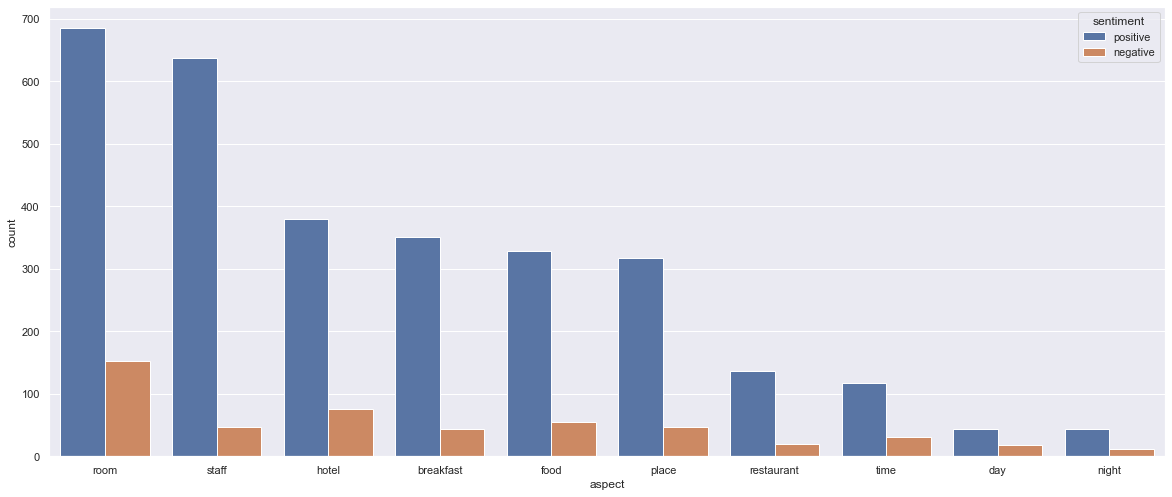

In [241]:
sns.barplot(x = "aspect", y="count", hue="sentiment", data=plot_first_five_aspects)

**Remarque:**
- remarque une dominance des sentiments positive à propos des premiers 10 aspects. Les aspects plus commenté positivement sont room, staff, hotel, breakfast, et food.
- les aspects room, hotel, food sont les plus commenté négativement.
- l'aspect room est apparu 2647 dans les commentaires prétraités, mais environ de 900 fois qu'il est extrait par l'algorithme de classification.
- l'aspect day est apparu 612 dans les commentaires prétraités, mais environ 80 fois qu'il est extrait par l'algorithme de classification.

#### Affichage des sentiments à propos des 10 derniers aspects.

In [228]:
groped_aspects_summary_[groped_aspects_summary_["sentiment"]=="positive"][-11:-1]["aspect"].tolist()

['child',
 'town',
 'desk',
 'evening',
 'reception',
 'morning',
 'star',
 'family',
 'year',
 'door']

<AxesSubplot:xlabel='aspect', ylabel='count'>

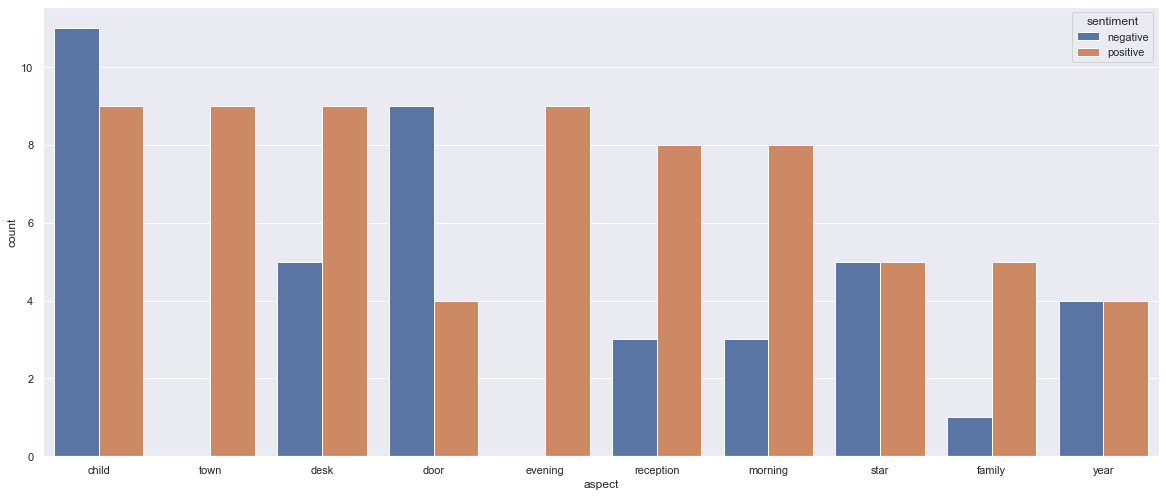

In [238]:
plot_last_five_aspects = groped_aspects_summary_.query("aspect==['child','town','desk','evening','reception','morning','star','family','year','door']")
sns.barplot(x = "aspect", y="count", hue = "sentiment", data=plot_last_five_aspects)

**Remarques:**
- il y a presque une égalité entre la répartition des sentiments positifs et négatifs dans les 10 derniers aspects.
- il y a des aspects qui ne contiennent que des sentiments négatifs comme l'aspect town et evening.

### Références
Articles :
- Multiaspect‐based opinion classification model for tourist reviews
- A Hybrid Co‑occurrence and Ranking‑based Approach for Detection of Implicit Aspects in Aspect‑Based Sentiment Analysis
- A novel deterministic approach for aspect-based opinion mining in tourism products reviews

Blogs :
- Aspect-Based Opinion Mining (NLP with Python)